In [5]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,weights,ggbreak,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [6]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [7]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [8]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)

Joining, by = "SeqProjID"


In [9]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plottingdr$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"
for_plotting_old_zscore = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [10]:
seasonal_info=read.csv("../../data/season_dates.csv",comment="#") %>%
    dplyr::mutate(StartDate=as.Date(StartDate,origin="1970-01-01",format="%Y-%m-%d"),
                  EndDate=as.Date(EndDate,origin="1970-01-01",format="%Y-%m-%d"))

get_season_from_date <- function(date_vect) {
    season_list = c()
    for (date_curr in date_vect) {
        selected_season = seasonal_info %>% dplyr::filter((StartDate <= date_curr)&(EndDate >= date_curr))
        if (length(selected_season)==0) {
            season_list = c(season_list,"Missing")
        } else {
            if (length(selected_season$Season) > 1) {
                print("YO what gives")
                print(selected_season$Season)
            }
            season_list = c(season_list,as.character(selected_season$Season))
        }
    }
    return(season_list)
}

means_within_seasons = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order)) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))
    #dplyr::mutate(Season = get_season_from_date(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))

## We first take the within-season mean, then calculate the means of those individual-season means across years to ensure we minimize uneven sampling bias.

## We create _weights_ for each sample value based on its year and season in order to compute weighted mean and standard deviation for the Z-score formula. As such, if we had 3 Spring timepoints in 2019, each of those samples would have a weight of 0.333 in the standard deviation and mean formulae for Spring. Meanwhile, if we had just one Spring timepoint in 2000, that sample has a weight of 1, since it's the only informative point we have for Spring from that year. We calculate the Z-score relative to the weighted mean and standard deviation for each season.

- if an organism was present in only 1 of the three samps for that season, they still would only get 0.33 and 0.33 weights for the two that they were present in.

In [11]:
total_in_season = means_within_seasons %>% 
    dplyr::distinct(Season,Year,FormattedDate) %>%
    dplyr::group_by(Season,Year) %>%
    dplyr::tally()

means_with_seasons_ = means_within_seasons %>% 
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::group_by(Season,Label) %>%
    dplyr::summarize(meanTPM = sum(TPM*Weights) / sum(Weights),
                     sdTPM = sqrt((sum(((TPM-sum(TPM*Weights) / sum(Weights))^2)*Weights) / 
                          (sum(Weights)*(length(Weights)-1)/length(Weights)))))

curr_cm="RF01960"
for_plotting_new = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))%>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::ungroup()

Joining, by = c("Year",
"Season")
`summarise()` has grouped
output by 'Season'. You can
override using the
`.groups` argument.
Joining, by = c("Year",
"Season")


In [12]:
means_with_seasons_ %>% dplyr::filter((Label=="MEND-TF-18S-366") & (Season=="Spring"))

Season,Label,meanTPM,sdTPM
<chr>,<chr>,<dbl>,<dbl>
Spring,MEND-TF-18S-366,0,0


In [13]:
for_plotting_new %>% dplyr::filter(is.na(ZScore)) %>%
    dplyr::select(Label,Phylum,Family,Class,TPM,Season,meanTPM,Year,sdTPM,ZScore)

Label,Phylum,Family,Class,TPM,Season,meanTPM,Year,sdTPM,ZScore
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MEND-TF-18S-366,Apicomplexa,Eucoccidiorida,Conoidasida,0,Spring,0,2013,0,NaN
MEND-TF-18S-366,Apicomplexa,Eucoccidiorida,Conoidasida,0,Spring,0,2013,0,NaN
MEND-TF-18S-8,Ascomycota,Pezizaceae,Pezizomycetes,0,Ice,0,2001,0,NaN
MEND-TF-18S-8,Ascomycota,Pezizaceae,Pezizomycetes,0,Ice,0,2001,0,NaN
MEND-TF-18S-73,Opisthokonta,Salpingoecidae,Choanoflagellata,0,Ice,0,2001,0,NaN
MEND-TF-18S-73,Opisthokonta,Salpingoecidae,Choanoflagellata,0,Ice,0,2001,0,NaN
MEND-TF-18S-302,Ciliophora,Ophryoglenina,Oligohymenophorea,0,Ice,0,2001,0,NaN
MEND-TF-18S-302,Ciliophora,Ophryoglenina,Oligohymenophorea,0,Ice,0,2001,0,NaN
MEND-TF-18S-330,Ciliophora,Acinetidae,Phyllopharyngea,0,Ice,0,2001,0,NaN


In [14]:
for_plotting_new %>% dplyr::rename(newZScore = ZScore) %>% dplyr::left_join(for_plotting_old_zscore) %>%
    dplyr::select(Year,ZScore,newZScore,Season,Label,Class,Domain,Family,Phylum) %>%
    dplyr::mutate(percDiff=(newZScore-ZScore)/ZScore) %>%
    dplyr::filter(sign(ZScore)!=sign(newZScore)) %>%
    dplyr::arrange(desc(abs(percDiff)))

Joining, by = c("V1.x",
"X.rname", "startpos",
"endpos", "numreads",
"covbases", "coverage",
"meandepth", "meanbaseq",
"meanmapq", "TPM",
"Sample", "AssemblyName",
"X.x", "totalreads",
"propreads", "X.y",
"AnalysisIDs", "Assembly",
"Raw", "SeqProjID",
"Analysis.Project.GOLD.Analysis.Project.ID",
"Analysis.Project.Analysis.Project.Name",
"Analysis.Project.Analysis.Project.Type",
"Analysis.Project.IMG.Submission.ID",
"Analysis.Project.Assembly.Method",
"Analysis.Project.Add.Date",
"Analysis.Project.IMG.Taxon.ID",
"Analysis.Project.ITS.Analysis.Project.ID",
"SampleDate", "type.x",
"clustnum.x", "seqlen.x",
"percid.x", "plus.x",
"a.x", "b.x", "aln.x",
"target.x", "Label",
"V1.y", "parent", "node",
"branch.length", "isTip",
"x", "y", "branch",
"angle", "TipLab",
"qseqid", "Lineage.x",
"TopLevel.x", "Group.x",
"Clade.x", "Subfamily.x",
"Subphylum.x",
"Subclass.x", "Suborder.x",
"Infraclass.x",
"Superorder.x",
"Superfamily.x", "type.y",
"clustnum.y", "seqlen.y",
"percid.y", "plus.y",
"a.y", "

Year,ZScore,newZScore,Season,Label,Class,Domain,Family,Phylum,percDiff
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2015,-1.067827e-04,1.00811433,Spring,MEND-TF-18S-108,,Eukaryota,Saprolegniaceae,Oomycota,-9441.8058
2015,-1.067827e-04,1.00811433,Spring,MEND-TF-18S-108,,Eukaryota,Saprolegniaceae,Oomycota,-9441.8058
2018,-1.025088e-04,0.19040801,LateSummer,MEND-TF-18S-173,Colpodellida,Eukaryota,Alphamonaceae,Apicomplexa,-1858.4800
2018,-1.025088e-04,0.19040801,LateSummer,MEND-TF-18S-173,Colpodellida,Eukaryota,Alphamonaceae,Apicomplexa,-1858.4800
2007,-3.650571e-04,0.64207016,LateSummer,MEND-TF-18S-19,Branchiopoda,Eukaryota,Daphniidae,Arthropoda,-1759.8210
2007,-3.650571e-04,0.64207016,LateSummer,MEND-TF-18S-19,Branchiopoda,Eukaryota,Daphniidae,Arthropoda,-1759.8210
2011,3.014348e-05,-0.04966859,LateSummer,MEND-TF-18S-307,Conoidasida,Eukaryota,Eucoccidiorida,Apicomplexa,-1648.7393
2011,3.014348e-05,-0.04966859,LateSummer,MEND-TF-18S-307,Conoidasida,Eukaryota,Eucoccidiorida,Apicomplexa,-1648.7393
2010,-1.376046e-03,2.18335553,Clearwater,MEND-TF-18S-252,Cryptophyceae,Eukaryota,Katablepharidaceae,Cryptophyta,-1587.6882


In [15]:
for_plotting=for_plotting_new

In [16]:
for_plotting$Weights

[1] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
    [7] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [13] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [19] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [25] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [31] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [37] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [43] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [49] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [55] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [61] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [67] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [73] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [79] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [85] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [91] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
   [97] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [103] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [109] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [115] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [121] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [127] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [133] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [139] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [145] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [151] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [157] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [163] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [169] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [175] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [181] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [187] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [193] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [199] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [205] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [211] 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000 0.25000000
  [217] 0.25000000 0.25000000 0.25000000 0.25000000 0.04347826 0.04347826
  [223] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [229] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [235] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [241] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [247] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [253] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [259] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [265] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [271] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [277] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [283] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [289] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [295] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [301] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [307] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [313] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [319] 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
  [325] 

In [63]:
t_test_2010 <- function(for_plotting, label, weights="none",weightsy="non",
                        test = "ks", alternative="greater", thres_year = 2009) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        if (weights=="none"){
            weights=rep(1,length(pre_2010$TPM))
            weightsy=rep(1,length(post_2010$TPM))
        } else {
            weights=pre_2010$Weights
            weightsy=post_2010$Weights
        }
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(wtd.t.test(pre_2010$TPM, post_2010$TPM,
                          weight=weights,weighty=weightsy,alternative=alternative))
    }
}
categorize_vals = data.frame()
for_plot_tax = for_plotting %>% dplyr::distinct(Phylum,Order,Class,Genus,Family,Label,Weights)
for (curr_ind in c(1:nrow(for_plot_tax))) {
    curr = for_plot_tax$Label[curr_ind]
    curr_pval = t_test_2010(for_plotting, curr, weights="Weight", weightsy="Weight",
                            test = "t", alternative="less", thres_year = 2010)$coefficients["p.value"]#$p.value
    if (curr_pval <= 0.05) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="IncreasedPost2010")
    } else if (curr_pval >= 0.95) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="DecreasedPost2010")
    } else {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval, "Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="NoChange")
    }
    categorize_vals = categorize_vals %>% dplyr::bind_rows(curr_df)
}
categorize_vals$Verdict[p.adjust(categorize_vals$p.value, "BH") <= 0.05] = "IncreasedPost2010"
categorize_vals$Verdict[p.adjust(1-categorize_vals$p.value, "BH") <= 0.05] = "DecreasedPost2010"
categorize_vals$Verdict[(p.adjust(1-categorize_vals$p.value, "BH") > 0.05) &
                        (p.adjust(categorize_vals$p.value, "BH") > 0.05)] = "NoChange"

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”


`summarise()` has grouped
output by 'YearCat',
'Label'. You can override
using the `.groups`
argument.
`geom_smooth()` using
formula = 'y ~ x'
Warning message:
“Removed 2 rows containing
non-finite values
(`stat_smooth()`).”
Warning message:
“Removed 2 rows containing
missing values
(`geom_point()`).”


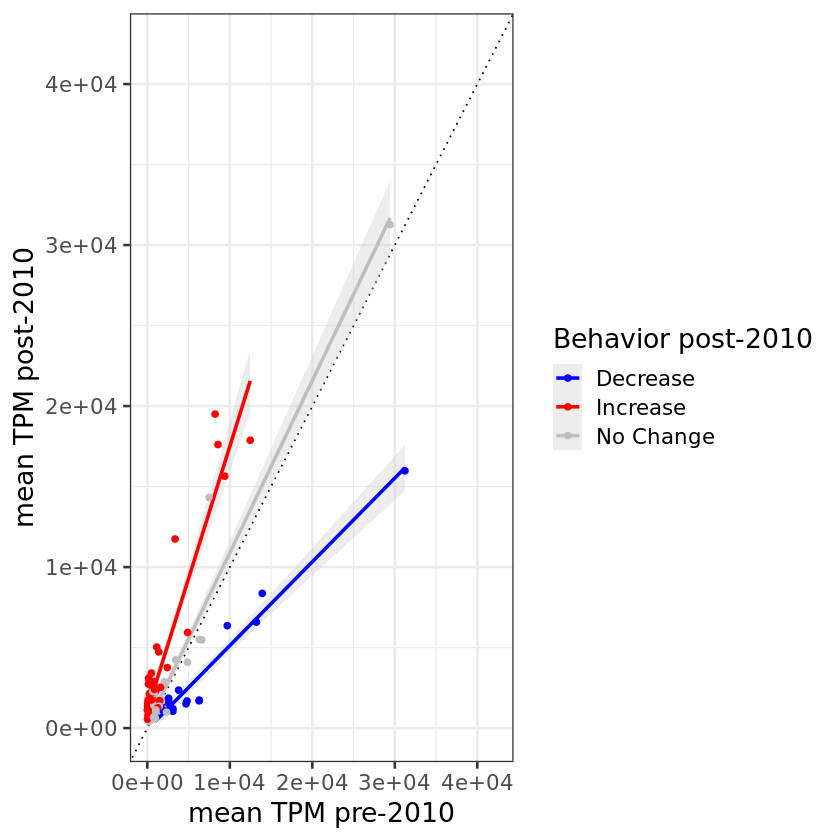

In [64]:
tpm_change_plot = ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label")) %>%
       dplyr::mutate(YearCat = dplyr::case_when(Year < 2010 ~ "pre2010",
                                                Year >= 2010 ~ "post2010")) %>%
       dplyr::group_by(YearCat,Label,Verdict) %>% dplyr::summarize(meanZScore = mean(TPM),
                                                           sdZScore = sd(ZScore)) %>%
       pivot_wider(id_cols = c(Label,Verdict), names_from = YearCat, values_from = meanZScore))  + 
    geom_abline(intercept=0,slope=1,linetype="dotted")+ 
    geom_smooth(aes(x = pre2010, y = post2010, color = Verdict,group = Verdict),
                method="lm",fill="lightgray")+
    geom_point(aes(x = pre2010, y = post2010, color = Verdict))+ theme_bw(base_size=16) + 
    #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    scale_color_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + 
    scale_y_continuous(labels = function(x) format(x, scientific = TRUE),
                       limits = c(min(for_plotting$TPM),max(for_plotting$TPM)/10))+ 
    scale_x_continuous(labels = function(x) format(x, scientific = TRUE),
                       limits = c(min(for_plotting$TPM),max(for_plotting$TPM)/10)) + 
    ylab("mean TPM post-2010") + xlab("mean TPM pre-2010")
#+ facet_wrap(~Label)
tpm_change_plot

In [65]:
head(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label",
                                                                                           "Phylum")) %>%
       dplyr::mutate(YearCat = dplyr::case_when(Year < 2010 ~ "pre2010",
                                                Year >= 2010 ~ "post2010")) %>%
       dplyr::group_by(YearCat,Label,Verdict,Phylum) %>% dplyr::summarize(meanZScore = mean(TPM),
                                                           sdZScore = sd(ZScore)) %>%
       pivot_wider(id_cols = c(Label,Verdict,Phylum), names_from = YearCat, values_from = meanZScore) %>%
       dplyr::mutate(percChange = pre2010/post2010) %>%
       dplyr::arrange(desc(abs(percChange))))

`summarise()` has grouped
output by 'YearCat',
'Label', 'Verdict'. You can
override using the
`.groups` argument.


Label,Verdict,Phylum,post2010,pre2010,percChange
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
MEND-TF-18S-251,DecreasedPost2010,Chlorophyta,1692.583,6275.267,3.707508
MEND-TF-18S-201,DecreasedPost2010,Chlorophyta,1740.128,6300.375,3.620639
MEND-TF-18S-379,DecreasedPost2010,Cercozoa,1506.114,4690.677,3.114423
MEND-TF-18S-38,DecreasedPost2010,Euglenozoa,1042.600,3086.439,2.960330
MEND-TF-18S-250,DecreasedPost2010,Cryptophyta,1683.604,4808.960,2.856349
MEND-TF-18S-211,DecreasedPost2010,Cercozoa,1196.786,3108.770,2.597599


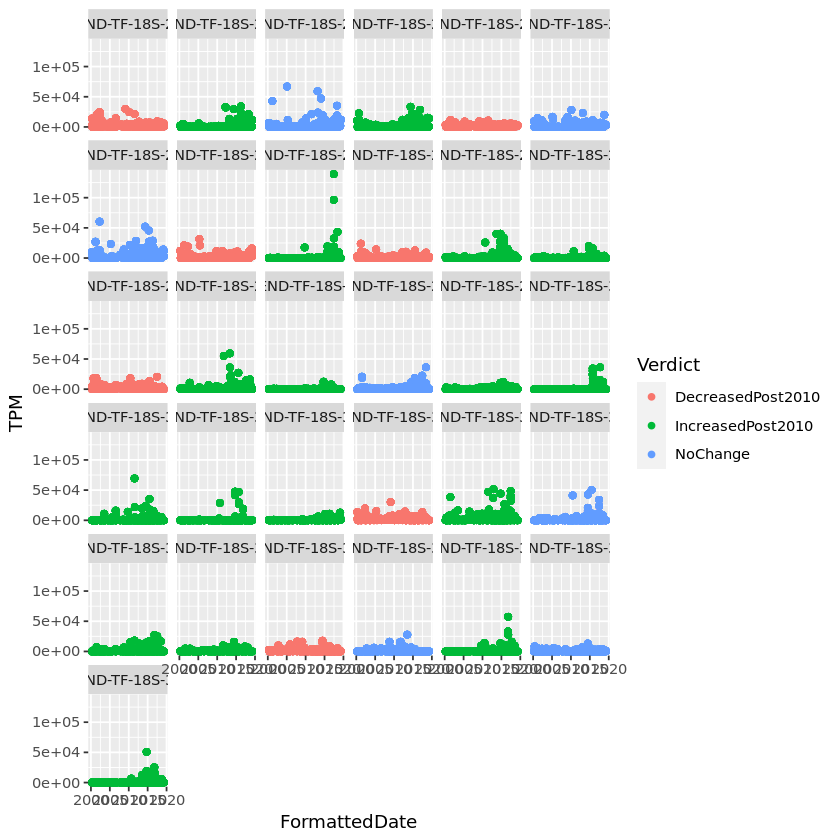

In [70]:
ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label",
                                                                                           "Phylum")) %>%
       dplyr::filter(Phylum=="Ciliophora")) + geom_point(aes(x=FormattedDate,y=TPM,color=Verdict)) + 
    facet_wrap(~Label)

`summarise()` has grouped
output by 'YearCat',
'Label', 'Verdict'. You can
override using the
`.groups` argument.
Warning message:
“Removed 10 rows containing
non-finite values
(`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing
missing values
(`geom_point()`).”


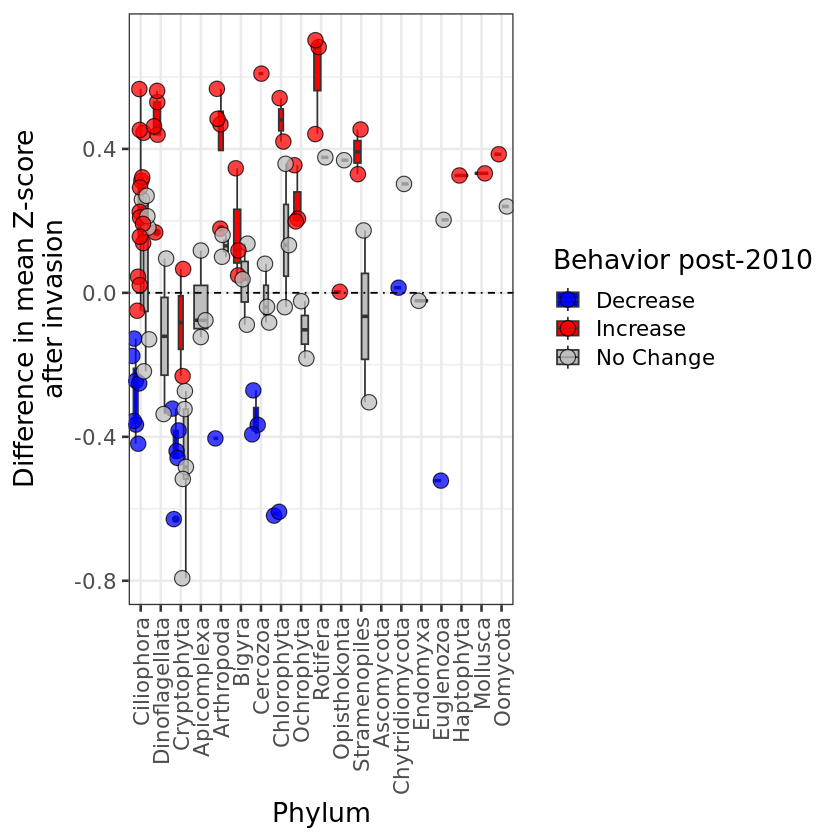

In [72]:
tallied_vals = categorize_vals %>% dplyr::distinct(Label,Verdict,Phylum,p.value) %>% 
    dplyr::group_by(Phylum,Verdict) %>% dplyr::tally() %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum))
sorted_phyla = unique((tallied_vals %>% dplyr::arrange(desc(n)))$Phylum)
tpm_change_plot = ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label",
                                                                                           "Phylum")) %>%
       dplyr::mutate(YearCat = dplyr::case_when(Year < 2010 ~ "pre2010",
                                                Year >= 2010 ~ "post2010")) %>%
       dplyr::group_by(YearCat,Label,Verdict,Phylum) %>% dplyr::summarize(meanZScore = mean(ZScore),
                                                           sdZScore = sd(ZScore)) %>%
       pivot_wider(id_cols = c(Label,Verdict,Phylum), names_from = YearCat, values_from = meanZScore) %>%
       dplyr::mutate(percChange = (post2010-pre2010))%>%
       dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum)))  + 
    geom_boxplot(aes(y = as.numeric(percChange), x = factor(Phylum,levels=sorted_phyla), 
                     fill=Verdict))+ theme_bw(base_size=16) + 
    geom_point(aes(y = as.numeric(percChange), x = factor(Phylum,levels=sorted_phyla), 
                     fill=Verdict),pch=21,size=4,
               color="black",position=position_jitterdodge(),
              alpha=0.75)+
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylab("Difference in mean Z-score\nafter invasion") + xlab("Phylum") + 
    geom_hline(aes(yintercept=0),linetype="dotdash")#+ scale_y_break(c(-800,-10),scales=5)
#+ facet_wrap(~Label)
tpm_change_plot

`summarise()` has grouped
output by 'YearCat',
'Label', 'Verdict'. You can
override using the
`.groups` argument.


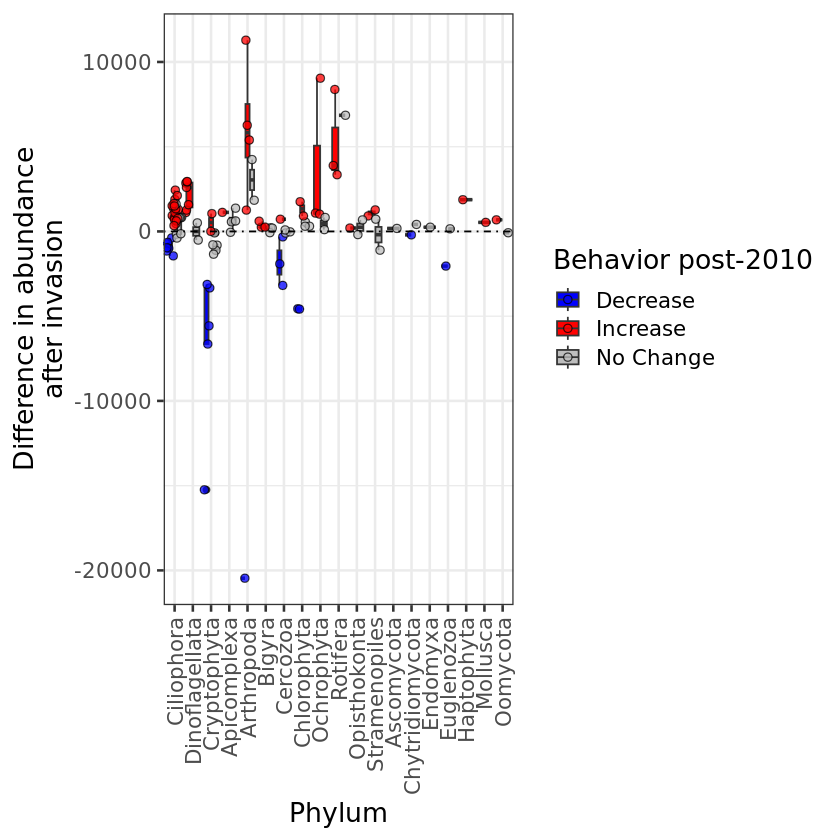

In [20]:
tallied_vals = categorize_vals %>% dplyr::distinct(Label,Verdict,Phylum,p.value) %>% 
    dplyr::group_by(Phylum,Verdict) %>% dplyr::tally() %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum))
sorted_phyla = unique((tallied_vals %>% dplyr::arrange(desc(n)))$Phylum)
tpm_change_plot_boxplot = ggplot(for_plotting %>% dplyr::left_join(categorize_vals, by = c("Label" = "Label",
                                                                                           "Phylum")) %>%
       dplyr::mutate(YearCat = dplyr::case_when(Year < 2010 ~ "pre2010",
                                                Year >= 2010 ~ "post2010")) %>%
       dplyr::group_by(YearCat,Label,Verdict,Phylum) %>% dplyr::summarize(meanZScore = mean(TPM),
                                                           sdZScore = sd(ZScore)) %>%
       pivot_wider(id_cols = c(Label,Verdict,Phylum), names_from = YearCat, values_from = meanZScore) %>%
       dplyr::mutate(percChange = post2010-pre2010)%>%
       dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum)))  + 
    geom_boxplot(aes(y = as.numeric(percChange), x = factor(Phylum,levels=sorted_phyla), 
                     fill=Verdict))+ theme_bw(base_size=16) + 
    geom_point(aes(y = as.numeric(percChange), x = factor(Phylum,levels=sorted_phyla), 
                     fill=Verdict),pch=21,size=2,color="black",position=position_jitterdodge(),
              alpha=0.75)+
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylab("Difference in abundance\nafter invasion") + xlab("Phylum") + 
    geom_hline(aes(yintercept=0),linetype="dotdash")
#+ facet_wrap(~Label)
tpm_change_plot_boxplot

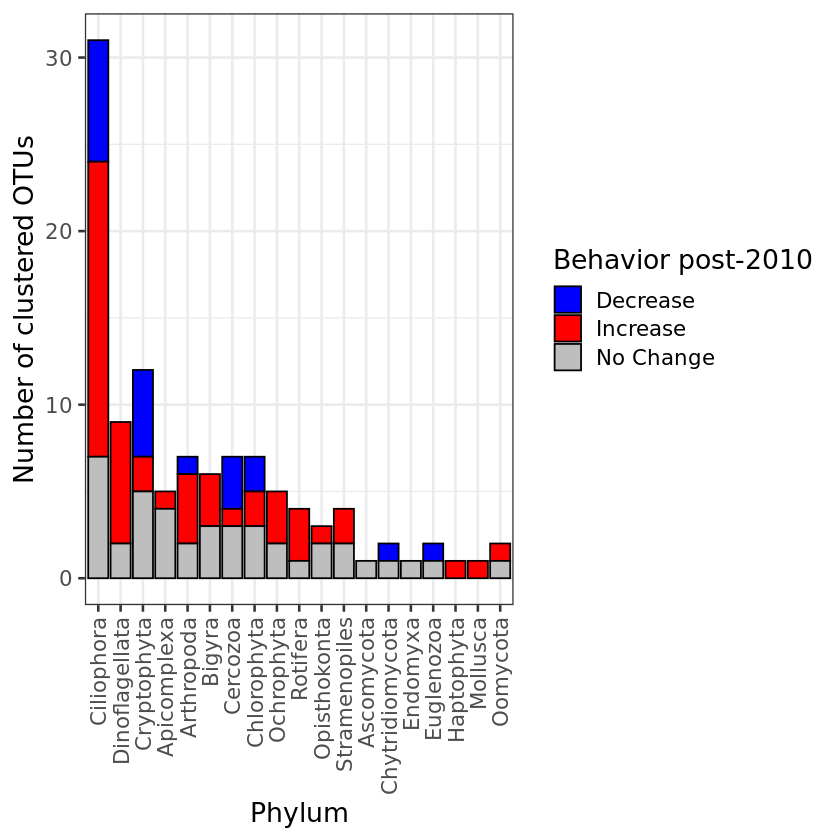

In [33]:
tallied_vals = categorize_vals %>% dplyr::distinct(Label,Verdict,Phylum,p.value) %>% 
    dplyr::group_by(Phylum,Verdict) %>% dplyr::tally() %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum=="Alveolata" ~ "Dinoflagellata",
                                           TRUE ~Phylum))
sorted_phyla = unique((tallied_vals %>% dplyr::arrange(desc(n)))$Phylum)
behavior_post_2010 = ggplot(tallied_vals)+
    geom_bar(aes(x = factor(Phylum,levels=sorted_phyla), y = n, fill = Verdict), stat = "identity", 
             position = "stack", color = "black")+ theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("DecreasedPost2010",
                                 "IncreasedPost2010",
                                 "NoChange"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") + 
    ylab("Number of clustered OTUs") + xlab("Phylum")
behavior_post_2010

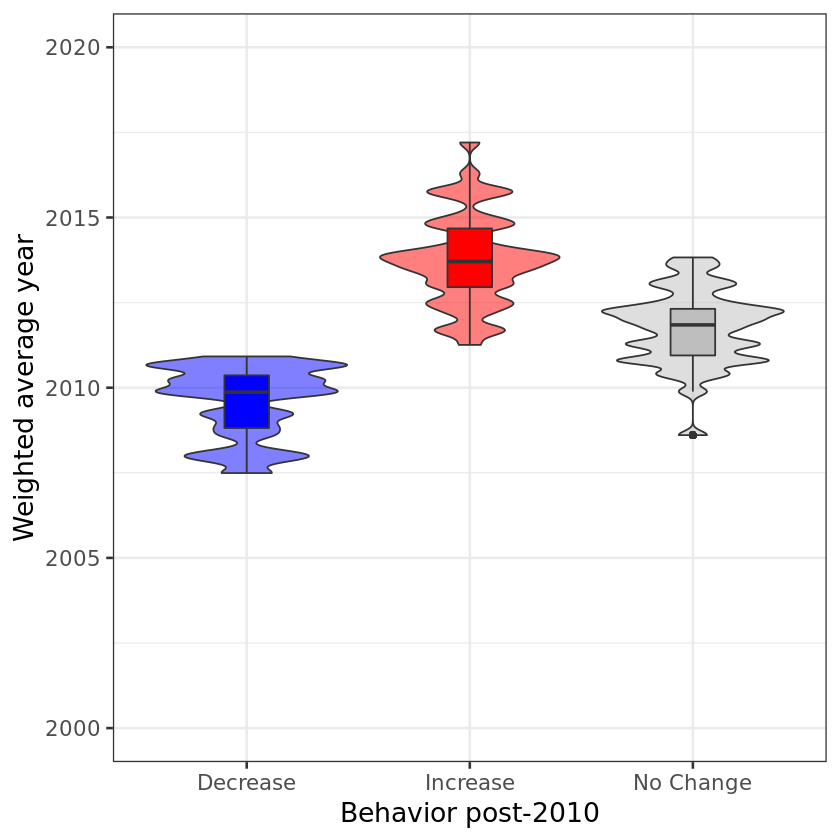

In [22]:
verdict_post_2010 = ggplot(for_plotting %>% dplyr::left_join(categorize_vals %>% 
                                                             dplyr::distinct(Label,Verdict,p.value), by = c("Label" = "Label")) %>%
    dplyr::group_by(Label,Verdict) %>%
    dplyr::filter(!is.na(Year)) %>%
    dplyr::mutate(WeightedYear = sum(TPM * Year,na.rm=TRUE) / sum(TPM,na.rm=TRUE)) %>%
    dplyr::mutate(Verdict = dplyr::case_when(Verdict == "NoChange" ~ "No Change",
                                             Verdict == "IncreasedPost2010" ~ "Increase",
                                             Verdict == "DecreasedPost2010" ~ "Decrease"))) + 
    geom_violin(aes(x = Verdict, y = WeightedYear,fill=Verdict), alpha = 0.5) + 
    geom_boxplot(aes(x = Verdict, y = WeightedYear,fill=Verdict), width=0.2) + ylim(c(2000,2020)) + 
    scale_fill_manual(values = c("blue","red", "grey"),
                      breaks = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      labels = c("Decrease",
                                 "Increase",
                                 "No Change"),
                      name = "Behavior post-2010") +
    theme_bw(base_size=16) + ylab("Weighted average year") + xlab("Behavior post-2010") + 
    theme(legend.position="none")
verdict_post_2010

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


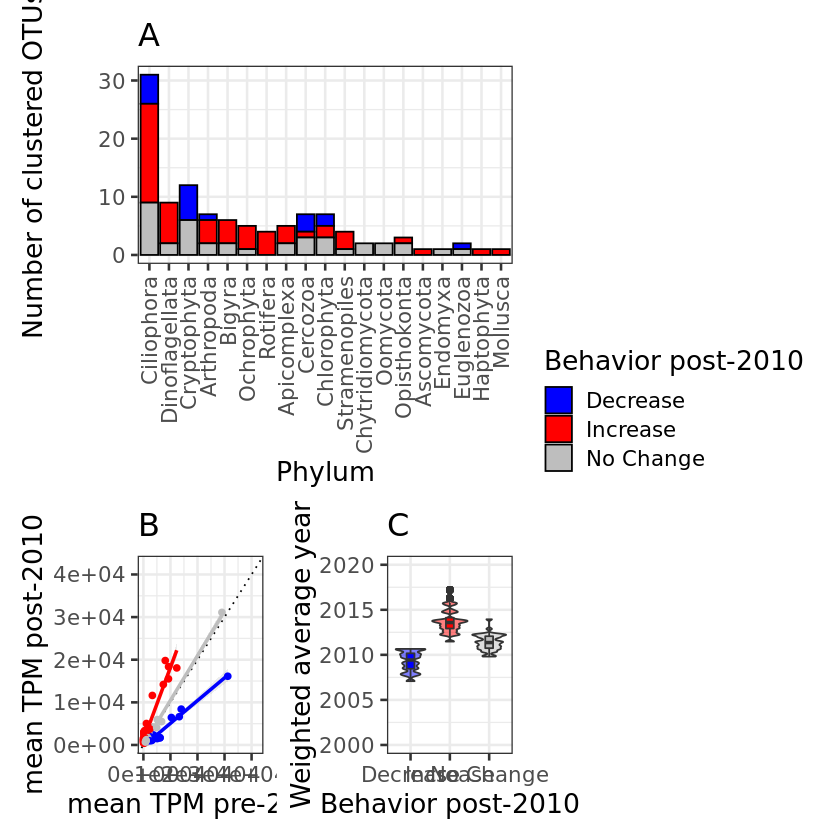

In [12]:
(behavior_post_2010 + ggtitle("A")) / ((tpm_change_plot + theme(legend.position="none") + ggtitle("B")) + 
 (verdict_post_2010 + ggtitle("C"))) +
  plot_layout(guides = 'collect')
ggsave(file = "../../figures/facetted_increase_plot.png", dpi = 400, width=12,height=10, units="in")
ggsave(file = "../../figures/facetted_increase_plot.pdf", dpi = 400, width=12,height=10, units="in")

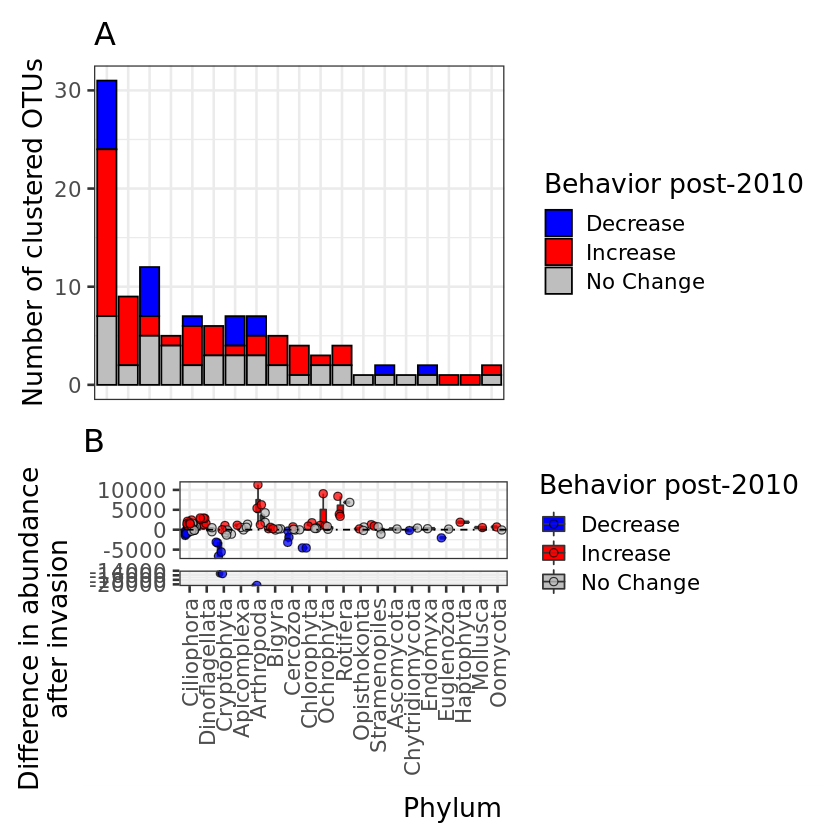

In [61]:
((behavior_post_2010 + ggtitle("A")+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.x=element_blank())) / 
  ((tpm_change_plot_boxplot + scale_y_break(c(-14200,-6500),scales=5) + ggtitle("B")))) +
  plot_layout(guides = 'collect')

ggsave(file = "../../figures/facetted_increase_plot_revised.png", dpi = 400, width=12,height=10, units="in")
ggsave(file = "../../figures/facetted_increase_plot_revised.pdf", dpi = 400, width=12,height=12, units="in")

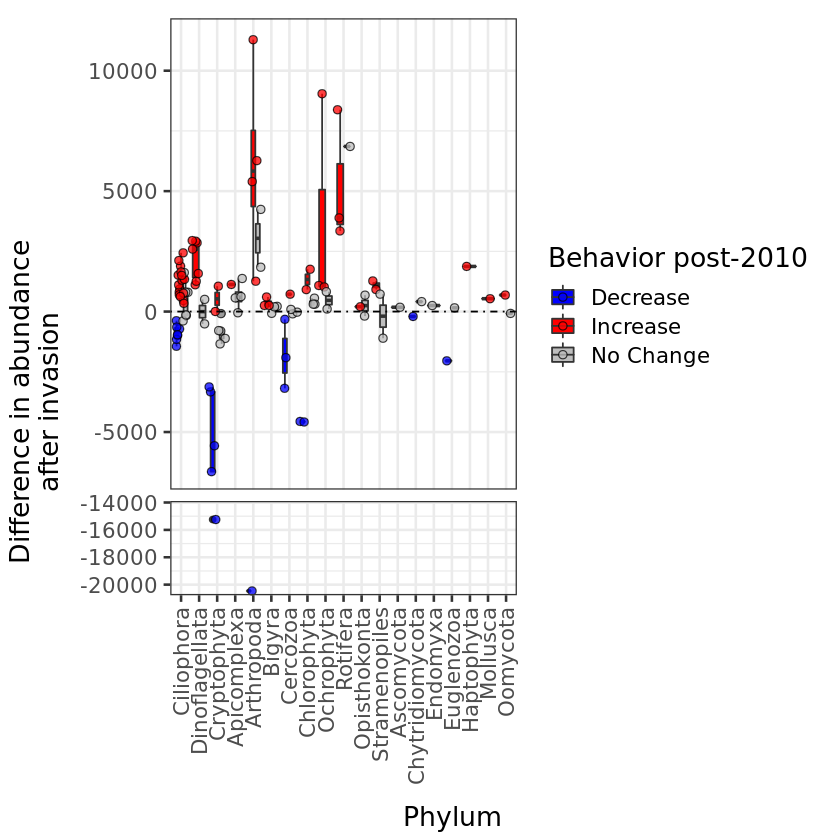

In [44]:
tpm_change_plot_boxplot + scale_y_break(c(-14200,-6500),scales=5)

Warning message:
“Removed 10 rows containing
non-finite values
(`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing
missing values
(`geom_point()`).”
Warning message:
“Removed 10 rows containing
non-finite values
(`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing
missing values
(`geom_point()`).”
Warning message:
“Removed 10 rows containing
non-finite values
(`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing
missing values
(`geom_point()`).”


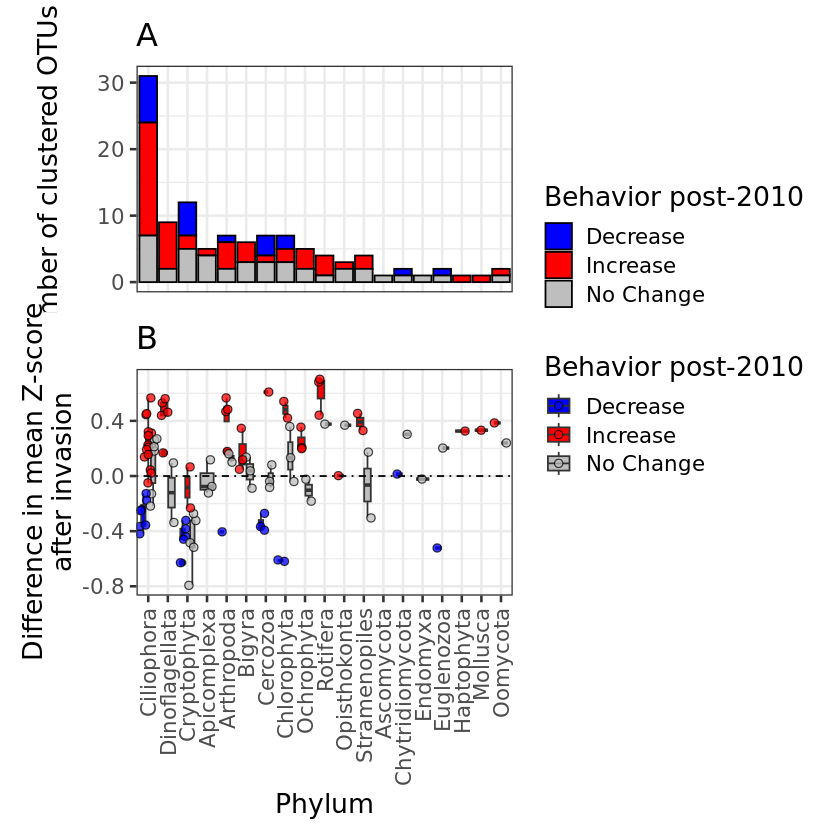

In [36]:
((behavior_post_2010 + ggtitle("A")+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.x=element_blank())) / 
  ((tpm_change_plot + ggtitle("B")))) +
  plot_layout(guides = 'collect')

ggsave(file = "../../figures/facetted_increase_plot_revised_2.png", dpi = 400, width=12,height=10, units="in")
ggsave(file = "../../figures/facetted_increase_plot_revised_2.pdf", dpi = 400, width=12,height=12, units="in")

Warning message:
“Removed 10 rows containing
non-finite values
(`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing
missing values
(`geom_point()`).”


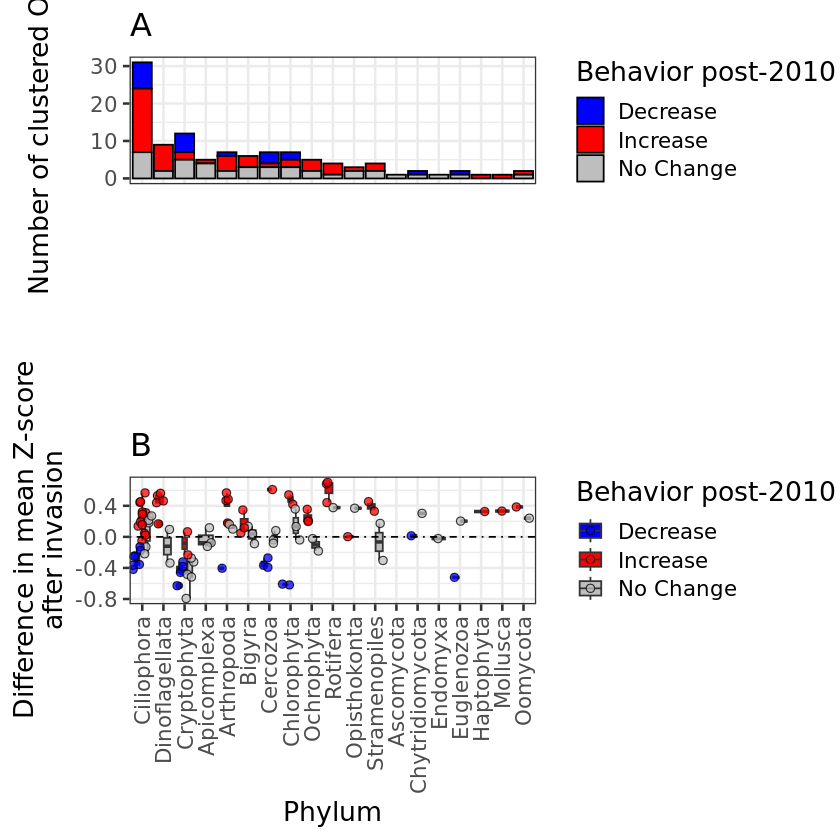

In [34]:
cowplot::plot_grid((behavior_post_2010 + ggtitle("A")+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.x=element_blank())),
                tpm_change_plot + scale_y_break(c(-14200,-6500),scales=5)+ggtitle("B"),nrow=2,align="hv")


ggsave(file = "../../figures/facetted_increase_plot_revised_2.png", dpi = 400, width=12,height=10, units="in")
ggsave(file = "../../figures/facetted_increase_plot_revised_2.pdf", dpi = 400, width=12,height=12, units="in")

In [1]:
tpm_change_plot_boxplot + scale_y_break(c(-14200,-6500),scales=5)+ggtitle("B")

ERROR: Error in eval(expr, envir, enclos): object 'tpm_change_plot_boxplot' not found
